In [1]:
import mailbox
import pandas as pd
import csv
import unicodedata
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})
from time import time

In [6]:
# path_data = 'data/gmail_data.mbox'
# mbox = mailbox.mbox(path_data)

In [7]:
# # print labels
# for i, key in enumerate(mbox[0].keys()):
#     print(i+1, key)

In [8]:
t0 = time()
subject = []
from_ = []
to = []
date = []
label = []
for i, message in enumerate(mbox):
    try:
        if i%2000 == 0:
            print(i, end=' ')
        subject.append(message['subject'])
        from_.append(message['from'])
        to.append(message['to'])
        date.append(message['date'])
        label.append(message['X-Gmail-Labels'])
    except:
        print(i, end=' ')
        print('subject', subject[i])
        print('from', from_[i])
        print('to', to[i])
        print('date', date[i])
        print('label', label[i])
print('\ntime: {:.1f} min'.format((time()-t0)/60))
print(len(subject))

In [11]:
df = pd.DataFrame()
df['subject'] = subject
df['from'] = from_
df['to'] = to
df['date'] = date
df['label'] = label

In [ ]:
def remove_accents(text):
    text = str(text)
    nfkd_norm = unicodedata.normalize('NFKD', text)
    text = nfkd_norm.encode('ASCII', 'ignore').decode('utf-8')
    return text

In [ ]:
df['subject'] = df['subject'].map(remove_accents)

In [ ]:
df.to_csv('data/gmail_data.csv', encoding='utf-8', index=False)

In [2]:
df = pd.read_csv('data/gmail_data.csv')

In [5]:
df[['subject', 'date', 'label']].head()

,subject,date,label
0,consulta DS,"Tue, 8 Aug 2017 11:20:05 +0200","Important,Sent"
1,Re: consulta DS,"Tue, 08 Aug 2017 10:35:39 +0100","Important,Inbox"
2,Re: consulta DS,"Tue, 08 Aug 2017 10:43:30 +0100","Important,Inbox"
3,Re: consulta DS,"Tue, 8 Aug 2017 13:16:37 +0200",Sent
4,NaN,"Sun, 19 Nov 2017 14:28:18 +0100","Important,Inbox"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69988 entries, 0 to 69987
Data columns (total 5 columns):
subject    66828 non-null object
from       69988 non-null object
to         55762 non-null object
date       56735 non-null object
label      69604 non-null object
dtypes: object(5)
memory usage: 2.7+ MB


Remove: chats and drafts

In [37]:
df = df[df['label'] != 'Chat']
df = df[df['label'] != 'Drafts']

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56556 entries, 0 to 69987
Data columns (total 5 columns):
subject    53666 non-null object
from       56556 non-null object
to         55707 non-null object
date       56221 non-null object
label      56172 non-null object
dtypes: object(5)
memory usage: 2.6+ MB


In [39]:
len(df)

56556

In [41]:
# df['date'] = df['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))

In [63]:
df[['date']].head()

,date
0,"Tue, 8 Aug 2017 11:20:05 +0200"
1,"Tue, 08 Aug 2017 10:35:39 +0100"
2,"Tue, 08 Aug 2017 10:43:30 +0100"
3,"Tue, 8 Aug 2017 13:16:37 +0200"
4,"Sun, 19 Nov 2017 14:28:18 +0100"


In [43]:
from datetime import datetime

datetime_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

In [44]:
datetime_object

datetime.datetime(2005, 6, 1, 13, 33)

In [62]:
df['date'][0].split(',')[1].split('+')[0]
str2ts(df['date'][0])

datetime.datetime(2017, 8, 8, 11, 20, 5)

In [59]:
def str2ts(date):
    ts = datetime.strptime(date.split(',')[1].split('+')[0], ' %d %b %Y %I:%M:%S ')
    return ts

In [27]:
def dow(date):
    days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    dayNumber=date.weekday()
    return days[dayNumber]

In [60]:
df['dow'] = df['date'].map(str2ts)

ValueError: time data ' 8 Aug 2017 13:16:37 ' does not match format ' %d %b %Y %I:%M:%S '

In [31]:
dow_tmp = []
for i in range(len(df)):
    try:
        dow_tmp.append(dow(df['date'][i]))
    except:
        print(df['date'][i], end=' ')

NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT NaT 

In [33]:
len(dow_tmp), len(df)

(56185, 56556)

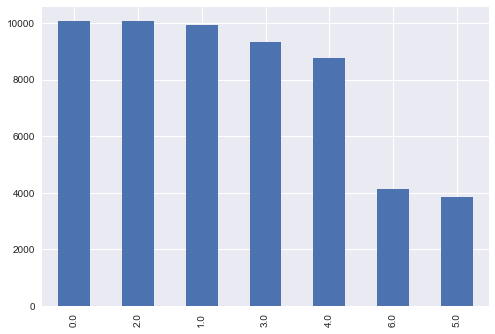

In [26]:
df['dow'].value_counts().plot(kind='bar'); #.index.tolist()

In [18]:
plt.hist(x);

NameError: name 'x' is not defined